### Step 1. Visualizing our data 

In [15]:
'''
References and resources: 
1. https://www.kaggle.com/c/data-science-bowl-2017/details/tutorial
2. https://luna16.grand-challenge.org/procedure/
3. https://pythonprogramming.net/cnn-tensorflow-convolutional-nerual-network-machine-learning-tutorial/
4. https://pythonprogramming.net/3d-convolutional-neural-network-machine-learning-tutorial/
5. https://www.kaggle.com/arnavkj95/data-science-bowl-2017/candidate-generation-and-luna16-preprocessing

'''
import numpy as np 
import pandas as pd 
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import dicom # for reading dicom files
import os    # for doing directory operations 

# Read the patient records
data_dir = 'C:/E!!/UIC/Semester SPRING 2017/IDS576_Adv_Predictive_Analytics/Project/Data from Kaggle/sample_images/'
patients = os.listdir(data_dir) # Get the list of patients. Each patient record is a directory

# Read the labels in a data frame: Patient ID | Associated labels
labels_df = pd.read_csv('C:/E!!/UIC/Semester SPRING 2017/IDS576_Adv_Predictive_Analytics/Project/Data from Kaggle/stage1_labels/stage1_labels.csv', index_col=0)
labels_df.head()


,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [42]:
# Information contained in a DICOM file for patient 1. 
for patient in patients[:1]: # Reading just the first record
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)] # Reading all the 134 dicom files for our patient 1
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))          # Sorting the slices by their depth or Z-coordinate
    print(len(slices),label)
    print(slices[0])

134 0
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.247817952625791837963403492891187883824
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: '00cba091fa4ad62cc3200a657aeb957e'
(0010, 0020) Patient ID                          LO: '00cba091fa4ad62cc3200a657aeb957e'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.86208730140539712382771890501772734277950692397709007305473
(0020, 000e) Series Instance UID                 UI: 2.25.11575877329635228925808596800269974740893519451784626046614
(0020, 0011) Series Number                       IS: '3'
(0020, 0012) Acquisition Number      

In [10]:
# The depth of our data for each patient is varying. 
# Lets see the height & width of the images... 
for patient in patients[:3]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(slices[0].pixel_array.shape, len(slices))
# After seeing the observations below, the width is same.
# slices[0].pixel_array is THE ATTRIBUTE that holds our image.

(512, 512) 134
(512, 512) 128
(512, 512) 133


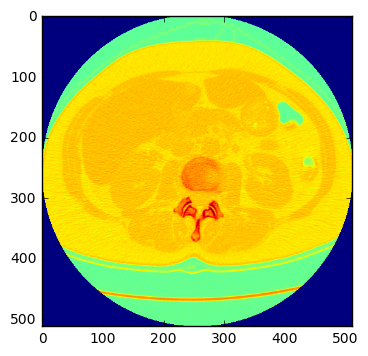

In [11]:
import matplotlib.pyplot as plt

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    #  Visualizing the first slice
    plt.imshow(slices[0].pixel_array)
    plt.show()

### Step 2. Image Preprocessing before feeding to our model

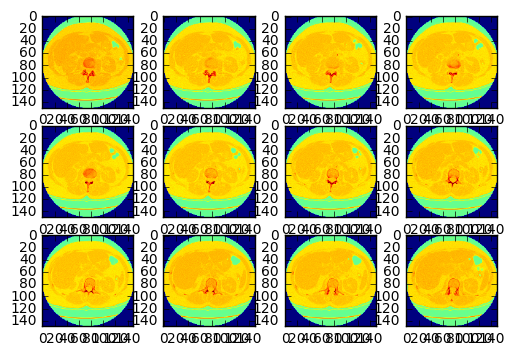

In [12]:
import cv2 # Used for down-sizing the images.
import numpy as np

IMG_PX_SIZE = 150 # Downsizing our images from 512*512 to 150*150  

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:12]): # Out of 134 slices, just visualizing the first 12 slices. 
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_img)
    plt.show()

In [43]:
# Not all scans have the same radiodensity

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)

    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    # https://en.wikipedia.org/wiki/Hounsfield_scale
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            slices[slice_number].pixel_array = slope * slices[slice_number].pixel_array.astype(np.float64)
            slices[slice_number].pixel_array = slices[slice_number].pixel_array.astype(np.int16)
            
        slices[slice_number].pixel_array += np.int16(intercept)
    
    return slices

In [44]:
import math

def chunks(l, n):
    # http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks 
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l) / len(l)

IMG_PX_SIZE = 150
HM_SLICES = 20

for patient in patients[:10]:
    try:
        label = labels_df.get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []
        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        chunk_sizes = math.ceil(len(slices) / HM_SLICES)
        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        print(len(slices), len(new_slices))
    except:
        # some patients don't have labels, so we'll just pass on this for now
        pass

134 20
128 19
133 19
110 19
203 19
280 20
123 18
164 19
244 19


In [17]:
# Fine tuning the above code to get uniform slices.
for patient in patients[:10]:
    try:
        label = labels_df.get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]

        chunk_sizes = math.ceil(len(slices) / HM_SLICES)


        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        print(len(slices), len(new_slices))
    except Exception as e:
        # again, some patients are not labeled, but JIC we still want the error if something
        # else is wrong with our code
        print(str(e))

134 20
128 20
133 20
110 20
203 20
'0b20184e0cd497028bdd155d9fb42dc9'
280 20
123 20
164 20
244 20


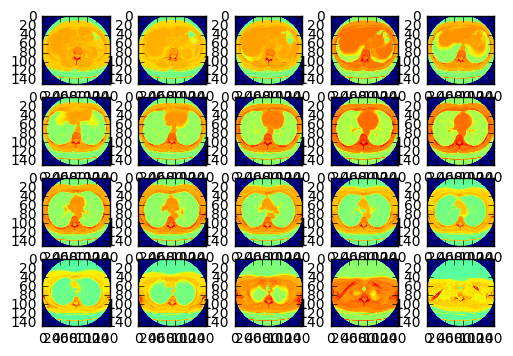

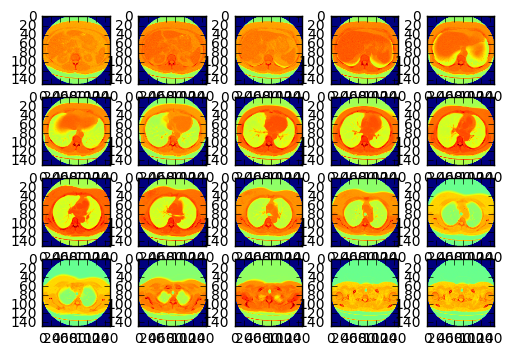

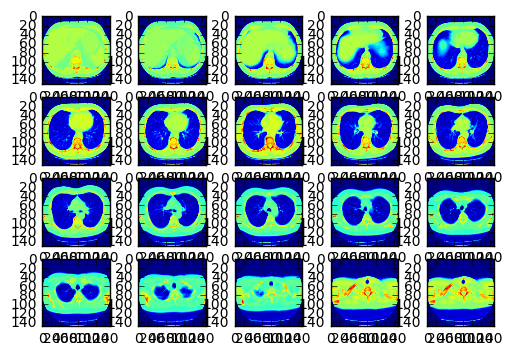

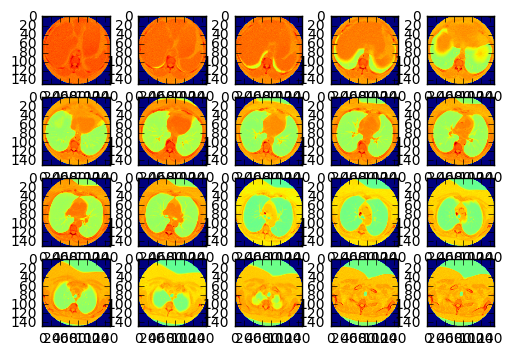

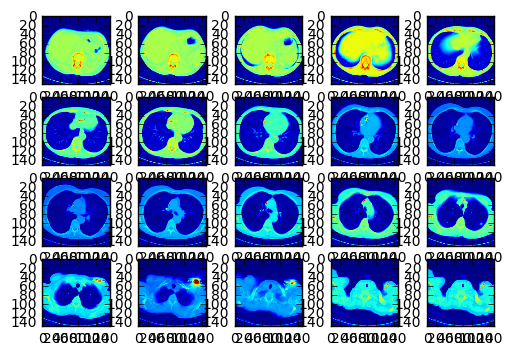

I think we have an unlabelled data for patient -  '0b20184e0cd497028bdd155d9fb42dc9'


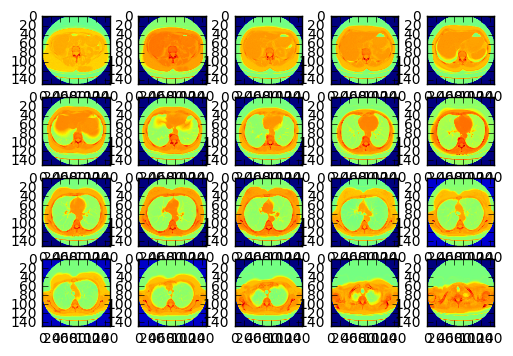

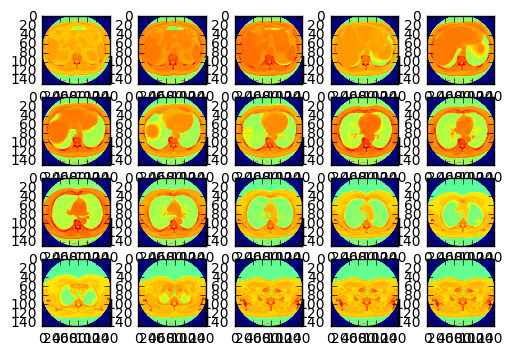

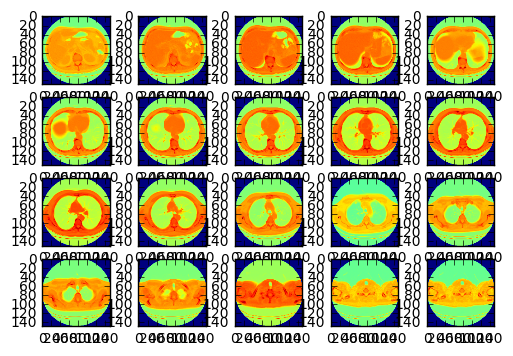

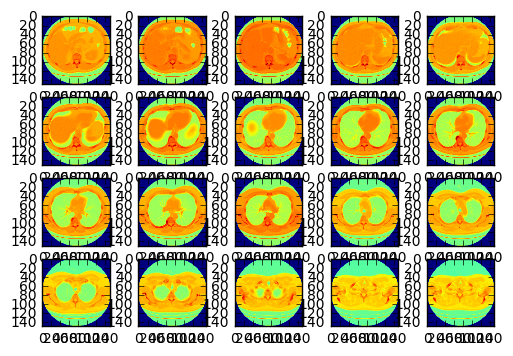

In [24]:
for patient in patients[:10]:
    try:        
        label = labels_df.get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]

        chunk_sizes = math.ceil(len(slices) / HM_SLICES)
        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice) # y.imshow(each_slice, cmap='gray')
        plt.show()
    except Exception as e:
        # again, some patients are not labeled, but JIC we still want the error if something
        # else is wrong with our code
        print("I think we have an unlabelled data for patient - ", str(e))

In [26]:
# defining a function to pre-process data
def process_data(patient,labels_df,img_px_size=50, hm_slices=20, visualize=False):
    
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = get_pixels_hu(slices)
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label

In [30]:
IMG_PX_SIZE = 50
SLICE_COUNT = 20
much_data = []
for num,patient in enumerate(patients):
    if num % 100 == 0:
        print(num)
    try:
        img_data,label = process_data(patient,labels_df,img_px_size=IMG_PX_SIZE, hm_slices=SLICE_COUNT)
        much_data.append([img_data,label])
    except KeyError as e:
        print('This is unlabeled data!')

np.save('muchdata-{}-{}-{}.npy'.format(IMG_PX_SIZE,IMG_PX_SIZE,SLICE_COUNT), much_data)

0
This is unlabeled data!


### Step 3. Build a computational graph

In [37]:
# https://pythonprogramming.net/3d-convolutional-neural-network-machine-learning-tutorial/

import tensorflow as tf
import numpy as np

IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

much_data = np.load('muchdata-50-50-20.npy')
# SMALLER DATA used in order to avoid OUT OF MEMORY ERROR !!
train_data = much_data[:-2]
validation_data = much_data[-2:]

### Step 4. Training

In [38]:
def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(prediction,y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 10
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    pass
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)

train_neural_network(x)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 1 completed out of 10 loss: 29229504256.0
Accuracy: 0.5
Epoch 2 completed out of 10 loss: 28379097472.0
Accuracy: 1.0
Epoch 3 completed out of 10 loss: 6342819712.0
Accuracy: 0.0
Epoch 4 completed out of 10 loss: 14830044736.0
Accuracy: 0.5
Epoch 5 completed out of 10 loss: 3889885696.0
Accuracy: 1.0
Epoch 6 completed out of 10 loss: 6073282016.0
Accuracy: 0.5
Epoch 7 completed out of 10 loss: 3802997484.0
Accuracy: 1.0
Epoch 8 completed out of 10 loss: 799325952.0
Accuracy: 1.0
Epoch 9 completed out of 10 loss: 897841168.0
Accuracy: 1.0
Epoch 10 completed out of 10 loss: 3306990784.0
Accuracy: 0.0
Done. Finishing accuracy:
Accuracy: 0.0
fitment percent: 1.0
